# Homework 1

Names: Mateen Qureshi and Yash Mittal

Class: CSCI 349 - Intro to Data Mining

Semester: 2019SP

Instructor: Brian King

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import os
import sys

### Part	2 – Applying frequent pattern mining: MovieLens

**Dataset source:** F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS). https://doi.org/10.1145/2827872

Setting the default encoding to UTF-8

In [2]:
if sys.getdefaultencoding() != 'utf-8':
    reload(sys)
    sys.setdefaultencoding('utf-8')

**Loading and preprocessing `ratings.csv` file**

In [3]:
def get_full_path(filename):
    return os.path.join(os.getcwd(), 'data', filename)

In [4]:
def preprocess_ratings(df):
    # drop rating and timestamp columns for now
    df = df.drop(['rating', 'timestamp'], axis=1)
    
    # downcast userId and movieId to int16 and int32 respectively
    df[df.columns] = df[df.columns].apply(pd.to_numeric,
                                          downcast='integer')
    return df

In [5]:
ratings_path = get_full_path('ratings.csv')
df_ratings = pd.read_csv(ratings_path)
original_mem_usage = df_ratings.memory_usage(deep=True).sum()

df_ratings = preprocess_ratings(df_ratings)
new_mem_usage = df_ratings.memory_usage(deep=True).sum()

mem_reduction = 100.0 * (original_mem_usage - new_mem_usage) / original_mem_usage
print('After preprocessing, memory consumption went down by {0:.2f}%'.format(mem_reduction))

After preprocessing, memory consumption went down by 81.25%


In [6]:
df_ratings.sample(5)

,userId,movieId
22151,147,5
19558,125,160271
61138,399,2571
84688,546,3160
27837,188,3469


**Converting ratings dataframe `df_ratings` to a transaction-based dataset**

In [7]:
ratings_grouped_by_user = pd.DataFrame(df_ratings.groupby('userId').movieId.apply(list))
ratings_dataset = ratings_grouped_by_user.movieId.tolist()

te = TransactionEncoder()
te_ary = te.fit(ratings_dataset).transform(ratings_dataset)
df_transactions = pd.DataFrame(te_ary,
                               columns=te.columns_,
                               index=ratings_grouped_by_user.index)
df_transactions.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
224,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
384,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
72,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
250,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We need to rename the columns in `df_transactions` from movie ids to movie names.

In [8]:
def preprocess_movies(df, drop=True):
    if drop:
        df = df.drop(['genres'], axis=1)
    
    # downcast movieId to int32
    df[['movieId']] = df[['movieId']].apply(pd.to_numeric,
                                            downcast='integer')
    return df

In [9]:
movies_path = get_full_path('movies.csv')
df_movies = pd.read_csv(movies_path)
df_movies = preprocess_movies(df_movies)
# df_movies.head(5)

In [10]:
id_to_title_dict = dict(zip(df_movies.movieId, df_movies.title))
df_transactions = df_transactions.rename(columns=id_to_title_dict)
df_transactions.sample(5)

,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
userId,,,,,,,,,,,,,,,,,,,,,
112,True,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
421,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
325,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
88,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Let's find the average number of users that rate a movie**

In [11]:
num_users = len(df_transactions)
aggregates = df_transactions.sum()
avg_num_users = aggregates[aggregates > 0.1 * num_users].mean()
print('Avg number of users rating one movie: {:.1f} users or {:.2f}% of all users'
          .format(avg_num_users, 100 * avg_num_users / len(df_transactions)))

Avg number of users rating one movie: 107.2 users or 17.58% of all users


Above, while calculating the average proportion of users that rate a movie, we ignored those movies which are rated by less than 10% of all users. This is later used to give us an estimate for the _minsup_ in Apriori.

**Now that we have a transaction-based dataset, we can use Apiori to find frequent itemsets and perform association rule mining.**

In [12]:
supp_1_itemsets = df_transactions.sum().sort_values(ascending=False)
_ = pd.DataFrame({'sup': supp_1_itemsets, 'rel_sup': supp_1_itemsets / len(df_transactions)})

Let's choose a _minsup_ of 0.20. Each of the frequent itemsets thus found is a set of movies rated by at least 20% of the users.

In [13]:
freq_itemsets = apriori(df_transactions, min_support=0.20, use_colnames=True)
freq_itemsets.sort_values('support', ascending=False, inplace=True)
freq_itemsets.head(10)

,support,itemsets
17,0.539344,(Forrest Gump (1994))
15,0.519672,"(Shawshank Redemption, The (1994))"
13,0.503279,(Pulp Fiction (1994))
31,0.457377,"(Silence of the Lambs, The (1991))"
62,0.455738,"(Matrix, The (1999))"
11,0.411475,(Star Wars: Episode IV - A New Hope (1977))
23,0.390164,(Jurassic Park (1993))
6,0.388525,(Braveheart (1995))
175,0.378689,"(Forrest Gump (1994), Shawshank Redemption, Th..."
149,0.377049,"(Forrest Gump (1994), Pulp Fiction (1994))"


In [14]:
rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.75)
print('Number of association rules generated: ', len(rules))

Number of association rules generated:  326


In [15]:
rules.sample(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
286,"(Terminator 2: Judgment Day (1991), Star Wars:...",(Star Wars: Episode V - The Empire Strikes Bac...,0.224590,0.345902,0.201639,0.897810,2.595565,0.123953,6.400820
319,"(Usual Suspects, The (1995), Pulp Fiction (1994))","(Silence of the Lambs, The (1991))",0.265574,0.457377,0.200000,0.753086,1.646533,0.078533,2.197623
40,"(Shawshank Redemption, The (1994), Silence of ...",(Forrest Gump (1994)),0.326230,0.539344,0.254098,0.778894,1.444151,0.078148,2.083420
34,(Raiders of the Lost Ark (Indiana Jones and th...,(Star Wars: Episode IV - A New Hope (1977)),0.327869,0.411475,0.260656,0.795000,1.932072,0.125746,2.870852
13,(Lord of the Rings: The Fellowship of the Ring...,"(Lord of the Rings: The Two Towers, The (2002))",0.324590,0.308197,0.272131,0.838384,2.720288,0.172094,4.280533
2,(Star Wars: Episode IV - A New Hope (1977)),(Star Wars: Episode V - The Empire Strikes Bac...,0.411475,0.345902,0.311475,0.756972,2.188403,0.169145,2.691454
159,"(Forrest Gump (1994), Star Wars: Episode IV - ...",(Star Wars: Episode VI - Return of the Jedi (1...,0.268852,0.321311,0.216393,0.804878,2.504978,0.130008,3.478279
6,"(Forrest Gump (1994), Pulp Fiction (1994))","(Shawshank Redemption, The (1994))",0.377049,0.519672,0.293443,0.778261,1.497600,0.097501,2.166185
123,"(Usual Suspects, The (1995), Shawshank Redempt...",(Pulp Fiction (1994)),0.267213,0.503279,0.222951,0.834356,1.657841,0.088468,2.998725
288,"(Forrest Gump (1994), Independence Day (a.k.a....",(Jurassic Park (1993)),0.242623,0.390164,0.201639,0.831081,2.130082,0.106977,3.610230


In [16]:
def scatter_plot_rules(rules):
    # refer: https://stackoverflow.com/a/6065493/4103546
    rules.sort_values('lift', inplace=True)
    sc = plt.scatter(rules['support'], rules['confidence'],
                     c=rules['lift'], cmap=plt.cm.get_cmap('OrRd'), alpha=0.8)
    cb = plt.colorbar(sc)
    cb.set_label('Lift')

    plt.title('Scatter plot for {} association rules'.format(len(rules)))
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.show()

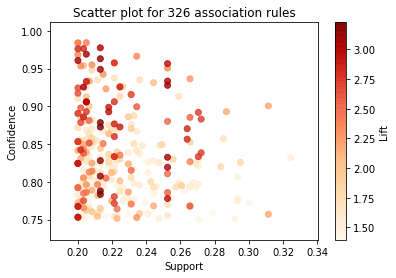

In [17]:
scatter_plot_rules(rules)

It's a bit hard to make sense of the scatter plot above. The three measures are all over the place, so picking strong rules is tricky.

Here, we notice that a lot of rules contain sequels of the same movie in both the antecedent and the consequent. Below, we filter out the rules for which a certain phrase (associated with a movie franchise) was used in both the antecedent and the consequent. This is done because such rules do not convey any _new_ information.

In [18]:
# sequels we could readily spot
common_names = ['Lord of the Rings', 'Star Wars', 'Godfather', 'Terminator']

for name in common_names:
    rules = rules[~((rules.antecedents.apply(lambda x: name in str(x)))
                  & (rules.consequents.apply(lambda x: name in str(x))))]

print('Number of association rules after filtering: ', len(rules))

Number of association rules after filtering:  232


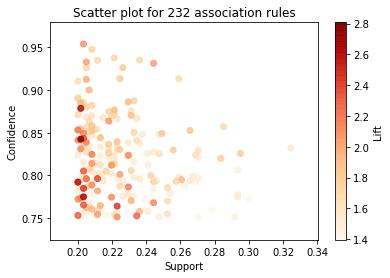

In [19]:
scatter_plot_rules(rules)

This is much better. Now we know that a relatively lower support value yields stronger rules.

In [20]:
rules.sort_values(['confidence', 'lift'], ascending=[False, False], inplace=True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
261,"(Forrest Gump (1994), Fight Club (1999), Pulp ...","(Matrix, The (1999))",0.213115,0.455738,0.203279,0.953846,2.092972,0.106154,11.792350
210,"(Jurassic Park (1993), Shawshank Redemption, T...",(Forrest Gump (1994)),0.219672,0.539344,0.208197,0.947761,1.757247,0.089718,8.818267
132,(Mrs. Doubtfire (1993)),(Forrest Gump (1994)),0.236066,0.539344,0.221311,0.937500,1.738222,0.093991,7.370492
74,"(Jurassic Park (1993), Shawshank Redemption, T...",(Forrest Gump (1994)),0.252459,0.539344,0.236066,0.935065,1.733707,0.099903,7.094098
185,"(Jurassic Park (1993), Apollo 13 (1995))",(Forrest Gump (1994)),0.226230,0.539344,0.211475,0.934783,1.733184,0.089460,7.063388


Following is a list of our top 10 rules:

In [21]:
TOP_K = 10

for _, row in rules.head(TOP_K).iterrows():
    print('{} → {}'.format(list(row.antecedents), list(row.consequents)))

['Forrest Gump (1994)', 'Fight Club (1999)', 'Pulp Fiction (1994)'] → ['Matrix, The (1999)']
['Jurassic Park (1993)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)'] → ['Forrest Gump (1994)']
['Mrs. Doubtfire (1993)'] → ['Forrest Gump (1994)']
['Jurassic Park (1993)', 'Shawshank Redemption, The (1994)'] → ['Forrest Gump (1994)']
['Jurassic Park (1993)', 'Apollo 13 (1995)'] → ['Forrest Gump (1994)']
['Fight Club (1999)', 'Star Wars: Episode IV - A New Hope (1977)'] → ['Matrix, The (1999)']
['Forrest Gump (1994)', 'Fight Club (1999)'] → ['Matrix, The (1999)']
['Seven (a.k.a. Se7en) (1995)', 'Shawshank Redemption, The (1994)'] → ['Pulp Fiction (1994)']
['Pretty Woman (1990)'] → ['Forrest Gump (1994)']
['Seven (a.k.a. Se7en) (1995)', 'Silence of the Lambs, The (1991)'] → ['Pulp Fiction (1994)']


---

One of the major shortcomings of the above model is that the association rules disregard user ratings altogether. Our goal now is to link these rules to genres so we can produce better informed recommendations. A typical case in point is:

> I just finished watching Shawshank Redemption. Which genres or movies can I watch next?
 

**Building a contingency table between antecedent and consequent genres**

In [22]:
movies_path = get_full_path('movies.csv')
df_movies = pd.read_csv(movies_path)

In [23]:
def get_genres(movie_list, genres):
    set_of_genres = set()
    movie_list = list(movie_list)
    for _ in movie_list:
        set_of_genres.update(df_movies[df_movies.title == _].iloc[0].genres.split('|'))
    return set_of_genres

rules.antecedents = rules['antecedents'].apply(get_genres, args=(df_movies,))
rules.consequents = rules['consequents'].apply(get_genres, args=(df_movies,))
rules.head()[['antecedents', 'consequents']]

,antecedents,consequents
261,"{Drama, Action, Crime, Thriller, War, Comedy, ...","{Sci-Fi, Action, Thriller}"
210,"{Drama, Comedy, Sci-Fi, Crime, Thriller, Adven...","{Drama, War, Comedy, Romance}"
132,"{Drama, Comedy}","{Drama, War, Comedy, Romance}"
74,"{Drama, Sci-Fi, Crime, Thriller, Adventure, Ac...","{Drama, War, Comedy, Romance}"
185,"{Drama, Sci-Fi, Thriller, Adventure, IMAX, Act...","{Drama, War, Comedy, Romance}"


In [24]:
conseqs = list(rules.consequents.apply(lambda x: list(x)))
antecs = list(rules.antecedents.apply(lambda x: list(x)))

cross_tab = pd.DataFrame(0,
                         index=np.unique([y for x in antecs for y in x]),
                         columns=np.unique([y for x in conseqs for y in x]),
                         dtype=float)

counter = pd.DataFrame(0,
                       index=np.unique([y for x in antecs for y in x]),
                       columns=np.unique([y for x in conseqs for y in x]),
                       dtype=int)

In [25]:
size = len(rules)
for i in range(len(rules)):
    curr_series = rules.iloc[i]
    antecs = curr_series['antecedents']
    conseqs = curr_series['consequents']
    for a in antecs:
        for c in conseqs:
            cross_tab.loc[a][c] += (size - i) / size
            counter.loc[a][c] += 1

cross_norm = cross_tab / counter
cross_norm

,Action,Adventure,Animation,Children,Comedy,Crime,Drama,Horror,Musical,Romance,Sci-Fi,Thriller,War
Action,0.520115,0.473707,NaN,NaN,0.555711,0.419730,0.502090,0.303879,NaN,0.594738,0.586293,0.550568,0.576121
Adventure,0.494253,0.378979,NaN,NaN,0.541544,0.419595,0.500000,0.474138,NaN,0.568292,0.544268,0.536066,0.554598
Animation,0.103448,0.732759,0.732759,0.732759,0.409483,NaN,0.301724,NaN,0.732759,0.301724,0.103448,0.103448,0.301724
Children,0.103448,0.732759,0.732759,0.732759,0.409483,NaN,0.301724,NaN,0.732759,0.301724,0.103448,0.103448,0.301724
Comedy,0.546858,0.559052,NaN,NaN,0.567951,0.411319,0.497089,0.201724,NaN,0.609606,0.595822,0.529154,0.593490
Crime,0.614616,0.618534,NaN,NaN,0.624323,0.500372,0.570860,0.201724,NaN,0.629089,0.656080,0.601524,0.629089
Drama,0.569945,0.532132,NaN,NaN,0.576201,0.430376,0.507335,0.201724,NaN,0.602439,0.608422,0.557296,0.592852
Fantasy,0.500392,0.562500,0.732759,0.732759,0.238147,0.334052,0.196121,NaN,0.732759,0.150144,0.510776,0.481322,0.150144
Horror,0.855603,NaN,NaN,NaN,0.621370,0.649867,0.592281,NaN,NaN,0.509100,0.855603,0.744612,0.509100
IMAX,0.258621,0.495690,0.732759,0.732759,0.629789,0.320402,0.530564,NaN,0.732759,0.782759,0.258621,0.320043,0.782759


We built this contingency table to help us determine which genres are most likely to occur as antecedent-consequent pairs. `cross_norm.index` and `cross_norm.columns` correspond to antecedents and consequents respectively.

**Visualizing the contingency table**

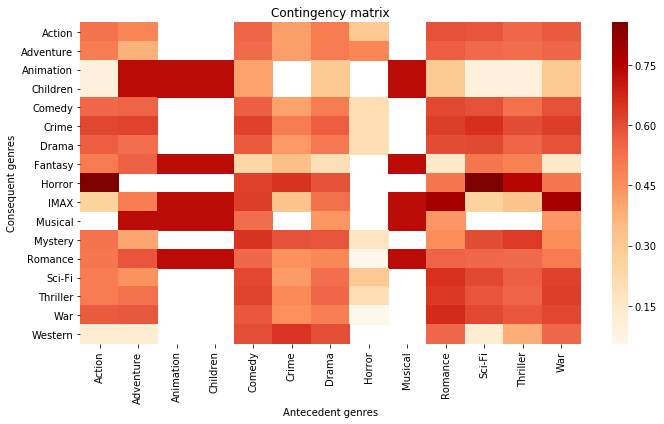

In [26]:
# refer: https://stackoverflow.com/a/29528483/4103546
fig = plt.figure(figsize=(10, 6))
sns.heatmap(cross_norm,
            cmap=plt.cm.get_cmap('OrRd'))

plt.title('Contingency matrix')
plt.xlabel('Antecedent genres')
plt.ylabel('Consequent genres')

plt.tight_layout()
plt.show()

**Given a genre, finding the most highly rated movies**

In [27]:
def preprocess_ratings_v2(df):
    # drop timestamp columns for now
    df = df.drop(['timestamp'], axis=1)
    
    df[df.columns] = df[df.columns].apply(pd.to_numeric,
                                          downcast='integer')
    df[['rating']] = df[['rating']].apply(pd.to_numeric,
                                          downcast='float')
    
    return df

In [28]:
ratings_path = get_full_path('ratings.csv')
df_ratings = pd.read_csv(ratings_path)
df_ratings = preprocess_ratings_v2(df_ratings)

As noted above, for recommendation purposes, we want to ignore the movies which are rated by only a few (here, below 10% of the users).

In [29]:
aggregates = df_ratings.groupby('movieId').size()
filtered_movie_ids = set(aggregates[aggregates > 0.1 * num_users].index)

In [106]:
def get_high_rates_movies(genre, n=5):
    avg_ratings = df_ratings.groupby('movieId').rating.mean()
    
    # movie ids for given genre
    movie_ids = set(df_movies[df_movies.genres.str.contains(genre, regex=False)].movieId)
    # movie ids which have been rated by many (more than 10% users)
    movie_ids_rated_by_many = movie_ids.intersection(filtered_movie_ids)
    
    sorted_genre_ratings = avg_ratings.filter(movie_ids_rated_by_many,
                                              axis='index').sort_values(ascending=False)
    
    high_rated_movies = list(sorted_genre_ratings.head(n).index)
    results = df_movies[df_movies.movieId.isin(high_rated_movies)]
    results.index = results.movieId
    results = results.drop('movieId', axis=1)
    results = results.reindex(high_rated_movies)
    results.loc[:,'avg_rating'] = sorted_genre_ratings.head(n).round(2)
    return results

Let's say we want to display top 5 recommendations for someone who just finished watching an _Horror_ movie.

In [107]:
get_high_rates_movies('Horror', n=5)

,title,genres,avg_rating
movieId,,,
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.16
1258,"Shining, The (1980)",Horror,4.08
1219,Psycho (1960),Crime|Horror,4.04
8874,Shaun of the Dead (2004),Comedy|Horror,4.01
1387,Jaws (1975),Action|Horror,4.01


**Putting it all together**

Back to the original use case. Given a movie, we want to display recommendations based on ratings and similar genres.

In [108]:
movie_name = 'Shawshank Redemption, The (1994)'

# movie genres (antecedent genres)
antecs_genres = df_movies[df_movies.title == movie_name].genres.str.split('|')
cross_norm_sliced = pd.Series(antecs_genres).apply(lambda x: cross_norm.loc[x]).sum()

# find the most likely consequent genre
next_genre = cross_norm_sliced.mean(axis=1, skipna=True).idxmax()

# get the most highly rated movies for the genre
results = get_high_rates_movies(next_genre, n=10)
results[results.title != movie_name]

,title,genres,avg_rating
movieId,,,
858,"Godfather, The (1972)",Crime|Drama,4.29
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.27
1221,"Godfather: Part II, The (1974)",Crime|Drama,4.26
48516,"Departed, The (2006)",Crime|Drama|Thriller,4.25
1213,Goodfellas (1990),Crime|Drama,4.25
58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.24
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.24
2329,American History X (1998),Crime|Drama,4.22
1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,4.20
